In [1]:
import os
from os.path import exists, isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pkg_resources import resource_stream, resource_filename, resource_exists

from Bio import SeqIO
from Bio.PDB import PDBList

from Bio.Seq import Seq
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
import io

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

import subprocess

from deepet.utils import to_binary, zero_padding
from deepet import my_callbacks
from deepet.run_inference import DeepETInference

import splits_helper_functions as splits

from tqdm import tqdm

Using TensorFlow backend.


## Example usage, obtain embeddings for sequences in fasta file

In [5]:
inf_obj = DeepETInference(model='ogt', layer='flatten_1')
df = inf_obj.run_inference(filepath='./data/5.5.1.5.fasta')
df.to_csv('my_sequences_predictions.tsv', sep='\t')

In [4]:
inf_obj = DeepETInference(model='ogt', layer='flatten_1')
df = inf_obj.get_embeddings(filepath='./data/5.5.1.5.fasta')
df.to_csv('my_sequences_embeddings.tsv', sep='\t')

## Occlusion

#### First cluster sequences

In [2]:
cluster_folder = join('./data', 'clusters')
if not exists(cluster_folder):
    os.makedirs(cluster_folder)
    
    
# cluster the fasta files
start_folder = './data'
splits.cluster_all_levels(start_folder, 
                   cluster_folder, 
                   filename='cleaned_enzyme_topts_with_structures')

# collect cluster members
df = splits.find_cluster_members(folder=cluster_folder, 
                          filename='cleaned_enzyme_topts_with_structures')
df.columns
display(df.describe())
display(df.head())
display(df.tail())

,cluster
count,1554.000000
mean,547.230373
std,324.402449
min,0.000000
25%,271.250000
50%,527.500000
75%,814.750000
max,1145.000000


,cluster,member
0,0,P0C6V1;ogt=nan;topt=22.0
1,1,P29837;ogt=nan;topt=22.0
2,2,Q91NH1;ogt=nan;topt=37.0
3,2,Q6YMS4;ogt=nan;topt=22.0
4,3,P27411;ogt=nan;topt=43.0


,cluster,member
1549,1142,Q75UV1;ogt=71;topt=70.0
1550,1143,B1Q4S7;ogt=25;topt=70.0
1551,1143,B1Q4V2;ogt=24;topt=68.0
1552,1144,P0A2W7;ogt=nan;topt=48.0
1553,1145,B3EWP2;ogt=nan;topt=37.0


#### Split the header to get UniProt id, OGT, and Topt

In [3]:
# split the header and rename
df_split = df.join(df.member.str.split(';', expand=True))
df_split.columns = ['cluster', 'member', 'uid', 'ogt', 'topt']
display(df_split.head())

# clean away the labels and convert to float
df_split.ogt = df_split.ogt.str.replace('ogt=', '').astype('float')
df_split.topt = df_split.topt.str.replace('topt=', '').astype('float')
display(df_split.head())

,cluster,member,uid,ogt,topt
0,0,P0C6V1;ogt=nan;topt=22.0,P0C6V1,ogt=nan,topt=22.0
1,1,P29837;ogt=nan;topt=22.0,P29837,ogt=nan,topt=22.0
2,2,Q91NH1;ogt=nan;topt=37.0,Q91NH1,ogt=nan,topt=37.0
3,2,Q6YMS4;ogt=nan;topt=22.0,Q6YMS4,ogt=nan,topt=22.0
4,3,P27411;ogt=nan;topt=43.0,P27411,ogt=nan,topt=43.0


,cluster,member,uid,ogt,topt
0,0,P0C6V1;ogt=nan;topt=22.0,P0C6V1,NaN,22.0
1,1,P29837;ogt=nan;topt=22.0,P29837,NaN,22.0
2,2,Q91NH1;ogt=nan;topt=37.0,Q91NH1,NaN,37.0
3,2,Q6YMS4;ogt=nan;topt=22.0,Q6YMS4,NaN,22.0
4,3,P27411;ogt=nan;topt=43.0,P27411,NaN,43.0


#### Which are the largest clusters with OGT?

In [4]:
df_split[df_split.ogt.notnull()].cluster.value_counts().nlargest(9)

432     9
748     9
327     8
455     7
506     7
139     7
371     6
1023    6
474     5
Name: cluster, dtype: int64

#### OGT distribution in the largest clusters

/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


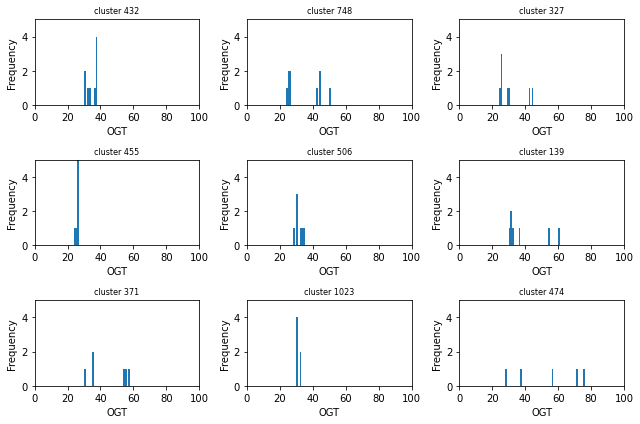

In [5]:
fig = plt.figure(figsize=(9, 6))


for i, cluster in enumerate(df_split[df_split.ogt.notnull()].cluster.value_counts().nlargest(9).index):
    plt.subplot(3, 3, i+1)
    p = plt.hist(df_split[df_split.cluster==cluster].ogt, bins=100, range=(0, 100))
    plt.xlim((0,100))
    plt.ylim((0, 5))
    plt.xlabel('OGT')
    plt.ylabel('Frequency')
    plt.title('cluster {}'.format(cluster), fontsize=8)
    
plt.tight_layout()

#### Which are the largest clusters with Topt?

In [6]:
df_split[df_split.topt.notnull()].cluster.value_counts().nlargest(9)

748    15
432    10
327     8
139     8
455     8
474     7
69      7
371     7
332     7
Name: cluster, dtype: int64

#### Topt distribution in the largest clusters

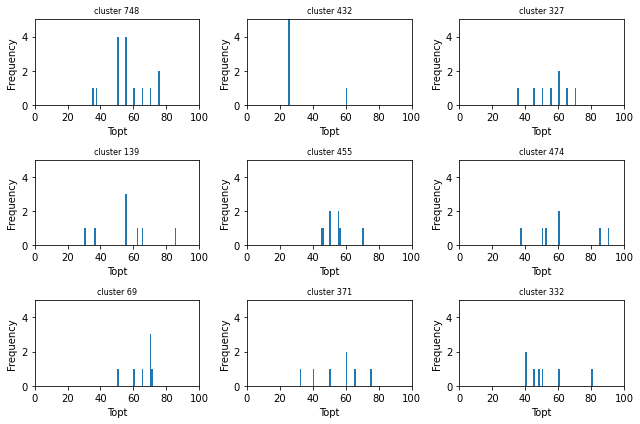

In [7]:
fig = plt.figure(figsize=(9, 6))


for i, cluster in enumerate(df_split[df_split.topt.notnull()].cluster.value_counts().nlargest(9).index):
    plt.subplot(3, 3, i+1)
    p = plt.hist(df_split[df_split.cluster==cluster].topt, bins=100, range=(0, 100))
    plt.xlim((0,100))
    plt.ylim((0, 5))
    plt.xlabel('Topt')
    plt.ylabel('Frequency')
    plt.title('cluster {}'.format(cluster), fontsize=8)
    
plt.tight_layout()

#### Sort one of the clusters on temperature

In [8]:
cluster = 474
df_cluster = df_split[(df_split.ogt.notnull()) & (df_split.cluster==cluster)]
df_cluster = df_cluster.sort_values('ogt', inplace=False)
display(df_cluster)

,cluster,member,uid,ogt,topt
701,474,H0HC94;ogt=28;topt=52.5,H0HC94,28.0,52.5
706,474,Q53EH2;ogt=37;topt=50.0,Q53EH2,37.0,50.0
707,474,P26208;ogt=56.0;topt=60.0,P26208,56.0,60.0
705,474,Q0GA07;ogt=71;topt=90.0,Q0GA07,71.0,90.0
704,474,A5IL97;ogt=75;topt=85.0,A5IL97,75.0,85.0


#### Obtain the sequences

In [9]:
def get_sequences(uid_list, fasta_path):
    '''
    Obtain protein sequences for a list of
    UniProt identifiers.
    '''
    sequences = {}

    for record in SeqIO.parse(fasta_path, 'fasta'):
        header = record.description
        seq = record.seq

        uid = header.split(';')[0]
        if uid in uid_list:
            sequences[uid] = str(record.seq)

    # put them in the same order as the data frame
    uid_list = []
    seq_list = []
    for uid in df_cluster.uid.values:
        uid_list.append(uid)
        seq_list.append(sequences[uid])
        
    return seq_list

fasta_path = join('./data', 'cleaned_enzyme_topts_with_structures.fasta')
uid_list = df_cluster.uid.values
seq_list = get_sequences(uid_list=uid_list, fasta_path=fasta_path)

#### Do sequence occlusion for the collected sequences

In [17]:
def occlude(seq_list, window, model):
    '''
    Cary out occlusion on sequences in the list.
    '''
    assert model in ['topt', 'ogt']
    
    inf_obj = DeepETInference(model=model, layer='flatten_1')

    preds = []
    changes = []
    z_scores = []
    for seq in tqdm(seq_list):
        wt_pred, change, z_score = inf_obj.occlusion_1d(seq, window=window)
        preds.append(wt_pred)

        # the first two and last three are missing (using window size of 3)
        changes.append(np.concatenate([np.array([np.nan for s in range(window-1)]), 
               change, 
               np.array([np.nan for s in range(window)])]))
        z_scores.append(np.concatenate([np.array([np.nan for s in range(window-1)]), 
               z_score, 
               np.array([np.nan for s in range(window)])]))
    return preds, changes, z_scores


window = 5
preds, changes, z_scores = occlude(seq_list, window, model='ogt')

100%|██████████| 5/5 [14:47<00:00, 177.40s/it]


#### How good are the predictions for these proteins?

Text(0.5, 1.0, 'cluster 474')

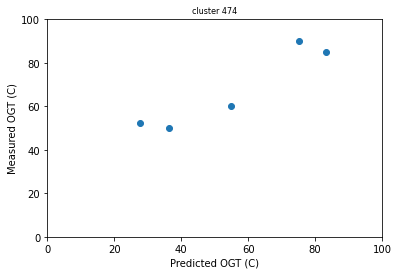

In [18]:
plt.scatter(x=preds, y=df_cluster.topt.values)
plt.xlim((0,100))
plt.ylim((0,100))
plt.xlabel('Predicted OGT (C)')
plt.ylabel('Measured OGT (C)')
plt.title('cluster {}'.format(cluster), fontsize=8)

#### Make a multiple sequence alignment to be able to adjust alignment of the scores

In [19]:
def align_sequences(uid_list, seq_list):
    '''
    Make a multiple sequence alignment of the sequences.
    Make sure result is in the same order.
    '''
    # assemble virtual fasta file
    record_list = []
    for uid, seq in zip(uid_list, seq_list):
        record_list.append('>{}\n{}'.format(uid, seq))
    records = '\n'.join(record_list)

    records_handle = io.StringIO(records) #turn string into a handle
    tempdata = records_handle.getvalue()

    # carry out the alignment
    muscle_cline = MuscleCommandline()
    stdout, stderr = muscle_cline(stdin=tempdata)

    with io.StringIO(stdout) as fasta:
        aln = SeqIO.parse(fasta, "fasta")

        alignment_dict = {}
        for entry in aln:
            header = entry.description
            seq = entry.seq

            alignment_dict[header] = (str(seq))

    # make an output list with the sequences in the correct order
    alignment = []
    for uid in uid_list:
        alignment.append(alignment_dict[uid])
    
    return alignment


alignment = align_sequences(uid_list, seq_list)

#### Visualize the alignment

In [141]:
# similarity

        

In [ ]:
# conservation


In [74]:
np.insert([1,2,3], [1,1], [3,4])

array([1, 3, 4, 2, 3])

In [76]:
self.pdb_obj.res_seqnum[chain] = np.insert(self.pdb_obj.res_seqnum[chain],
                                        self.pdb_obj.structure_gaps[chain],
                                        np.choose(self.pdb_obj.structure_gaps[chain], np.array(self.pdb_obj.seqres_seqnum[chain])))


array([1, 3, 5])

#### Fill up the z-score with NaN, where the multiple sequence alignment has gaps

In [20]:
def add_gaps_to_scores(z_scores, changes, alignment):
    '''
    Add NaNs to the Z-scores and changes, corresponding
    to the multiple alignment positions where there are gaps.
    '''
    z_scores_fixed = []
    changes_fixed = []
    for seq_idx in range(0, len(alignment)):

        insertions = []
        real_aa_counter = 0
        for pos_idx in range(0, len(alignment[seq_idx])):
            if alignment[seq_idx][pos_idx] == '-':
                insertions.append(real_aa_counter)
            else:
                real_aa_counter += 1

        z_scores_fixed.append(np.insert(z_scores[seq_idx], insertions, np.nan))
        changes_fixed.append(np.insert(changes[seq_idx], insertions, np.nan))
        
    return z_scores_fixed, changes_fixed


z_scores_fixed, changes_fixed = add_gaps_to_scores(z_scores, changes, alignment)

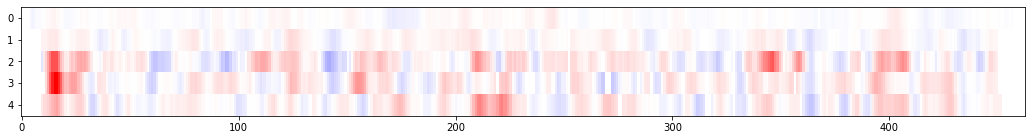

In [21]:
# visualize the percent changes
fig, ax = plt.subplots(figsize=(18, 2))

data = np.array(changes_fixed)
ax.imshow(data,
         interpolation='none',
         cmap='bwr',
         aspect='auto',
         vmin=-np.nanmax(np.abs(data)),
         vmax=np.nanmax(np.abs(data)))

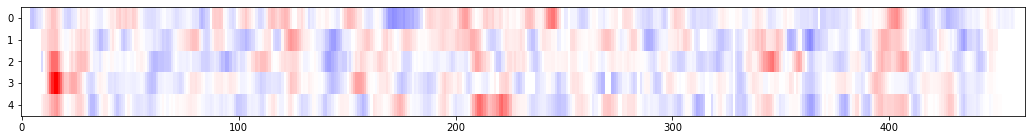

In [22]:
# visualize the z-scores
fig, ax = plt.subplots(figsize=(18, 2))

data = np.array(z_scores_fixed)
ax.imshow(data,
         interpolation='none',
         cmap='bwr',
         aspect='auto',
         vmin=-np.nanmax(np.abs(data)),
         vmax=np.nanmax(np.abs(data)))

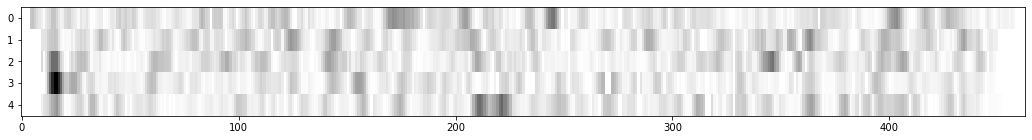

In [31]:
# visualize attention
fig, ax = plt.subplots(figsize=(18, 2))

data = np.array(z_scores_fixed)
ax.imshow(np.abs(data),
         interpolation='none',
         cmap='gray_r',
         aspect='auto',
         vmin=0,
         vmax=np.nanmax(np.abs(data)))

In [38]:
uid = uid_list[0]
uid

'H0HC94'

#### 3d occlusion

In [169]:
from Bio import SeqIO
inf_obj = DeepETInference(model='ogt', layer='flatten_1')

# parse the structure
# parser_obj = pfc.PDBReader(join('./data', 'pdb', 'Q47RA9_5n2i.pdb'), join('./data', 'Q47RA9_5n2i_temp.pdb'))
parser_obj = pfc.PDBReader('./data/1r3u.pdb', './data/1r3u_temp.pdb')

# compute distance matrix
dist_obj = pfc.PDBDistances(parser_obj)

dist_obj.intra_chain_pairwise_aa_distance_matrix()
dist_mat_df = dist_obj.feature_pdm_intra

# get th sequence and convert to binary
seq = to_binary(''.join(dist_obj.pdb_obj.seqres['A']).rstrip('*'))

ALANINE = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # sets global variable ALANINE as a one hot representation of alanine
NOTHING = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # sets global variable NOTHING as a one hot representation that's empty
PADDING = 2000
radius = 5


# first predict the unchanged sequence
original_seq = zero_padding(seq, PADDING)
wt_pred = inf_obj.model.predict( original_seq.reshape([1, original_seq.shape[0], original_seq.shape[1]]) )[0]

size_seq = len(seq)
start = dist_mat_df.index.values[0]-1
end = dist_mat_df.index.values[-1]

# determine which "contacts" are within a specific radius, as boolean array
contacts_bool = np.zeros([size_seq, size_seq], dtype=bool)
contacts_bool[start:end, start:end] = dist_mat_df.values[:, :] < radius

seqs = []
for i in range(contacts_bool.shape[0]):
    # I also want to zero out the amino acid under consideration
    contacts_bool[i][i] = True
    
    # for each index (aa pos) occlude everything it is in proximity to (but neighbors are excempt)
    tmp = np.zeros([seq.shape[0], seq.shape[1]])
    tmp[contacts_bool[i,:], :] = NOTHING # Setting all amino acids within radius to nothing
    print(sum(contacts_bool[i,:]))
    tmp[~contacts_bool[i,:], :] = seq[~contacts_bool[i,:], :] # For the non-touching positions, add in the amino acids
    
    #pads sequence to constant length of PADDING to fit model
    tmp = zero_padding(tmp, PADDING) 
    seqs.append(tmp)

seqs = np.array(seqs)
    
# predict for the occluded sequences
predictions = inf_obj.model.predict(seqs)

# compute the change in temperature, as a fraction of the WT prediction
change = (wt_pred - predictions) / wt_pred

# compute a z-score
z_score = (change-np.mean(change))/np.std(change)

/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
2
2
3
1
2
1
1
1
1
1
1
1
1
3
1
1
2
1
1
1
3
1
1
3
2
3
4
1
1
3
1
2
1
3
3
1
3
2
1
1
2
1
1
2
2
2
1
2
1
2
2
1
3
1
1
4
2
2
3
2
2
1
3
3
1
1
2
5
3
2
2
1
2
2
1
2
1
2
1
3
2
2
4
3
4
1
2
2
2
3
2
3
3
3
3
3
2
2
2
2
1
1
1
1
1
1
1
1
2
4
2
2
3
2
2
2
3
2
2
2
3
1
1
3
1
2
3
1
1
1
2
2
2
2
1
1
1
1
1
1
2
1
1
3
4
2
4
3
2
1
1
1
1
3
3
1
2
2
2
3
1
3
1
3
1
2
1
1
1


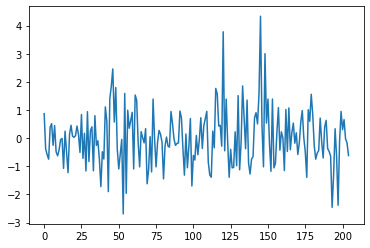

In [170]:
plt.plot(z_score)

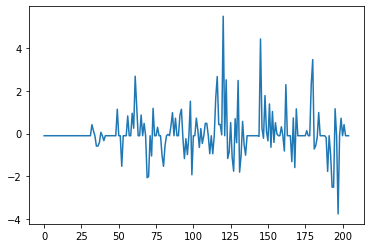

In [160]:
plt.plot(z_score)

In [164]:
seqs[1][1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [165]:
dist_obj.pdb_obj.seqres['A']

['M',
 'A',
 'S',
 'M',
 'T',
 'G',
 'G',
 'Q',
 'Q',
 'M',
 'G',
 'R',
 'G',
 'S',
 'S',
 'T',
 'S',
 'L',
 'Y',
 'K',
 'K',
 'A',
 'G',
 'L',
 'M',
 'P',
 'S',
 'P',
 'M',
 'E',
 'D',
 'I',
 'E',
 'E',
 'I',
 'L',
 'I',
 'T',
 'E',
 'E',
 'Q',
 'L',
 'K',
 'A',
 'K',
 'V',
 'K',
 'E',
 'L',
 'G',
 'E',
 'M',
 'I',
 'T',
 'R',
 'D',
 'Y',
 'E',
 'G',
 'K',
 'D',
 'L',
 'V',
 'L',
 'I',
 'G',
 'V',
 'L',
 'K',
 'G',
 'A',
 'I',
 'M',
 'F',
 'M',
 'S',
 'G',
 'L',
 'S',
 'R',
 'A',
 'I',
 'D',
 'L',
 'P',
 'L',
 'S',
 'I',
 'D',
 'F',
 'L',
 'A',
 'V',
 'S',
 'S',
 'Y',
 'G',
 'S',
 'S',
 'T',
 'K',
 'S',
 'S',
 'G',
 'I',
 'V',
 'K',
 'I',
 'I',
 'K',
 'D',
 'H',
 'D',
 'I',
 'D',
 'I',
 'E',
 'G',
 'K',
 'D',
 'V',
 'L',
 'I',
 'V',
 'E',
 'D',
 'I',
 'I',
 'D',
 'S',
 'G',
 'L',
 'T',
 'L',
 'A',
 'Y',
 'L',
 'R',
 'E',
 'T',
 'L',
 'L',
 'G',
 'R',
 'K',
 'P',
 'R',
 'S',
 'L',
 'K',
 'I',
 'C',
 'T',
 'I',
 'L',
 'D',
 'K',
 'P',
 'E',
 'R',
 'R',
 'E',
 'A',
 'D',
 'V',
 'K',
 'V'

In [168]:
contacts_bool.shape

(205, 205)

### Other stuff

In [40]:
### Need to fix this to ensure I'm actually coloring the correct position ##

seq = seq_list[0]
z_score = z_scores[0]
pdb_id = 'modbase'

outlines = []
outlines.append('bg_color white')
outlines.append('as cartoon')
outlines.append('set cartoon_discrete_colors, 1')
outlines.append('set cartoon_oval_length, 1.0')
outlines.append('set cartoon_oval_width, 0.2')
outlines.append('set ray_trace_mode, 1')
outlines.append('set ray_trace_gain, 0.1')
outlines.append('set ray_shadows, 0')
outlines.append('set ambient, 2')
outlines.append('set antialias, 3')
outlines.append('unset specular')

# prepare the colormap
cmap = matplotlib.cm.get_cmap('bwr')

# a data normalizer
norm = matplotlib.colors.Normalize(vmin=-abs(z_score).max(), vmax=abs(z_score).max())

for i in range(0, len(seq)):
    # get the rgba color for this value
    if i < len(z_score):
        val = z_score[i]
        
        if val == np.nan:
            color = '0xFFFFFF'
        else:
            rgba = cmap(norm(val))

            # convert to hex
            hex_col = matplotlib.colors.to_hex(rgba, keep_alpha=False)
            color = hex_col.upper().replace('#', '0x')
        
    else:
        color = '0xFFFFFF'
    
    # color by category
    outlines.append('color {}, resi {}'.format(color, i+1))
        
# hide hydeogen atoms
outlines.append('hide (hydro)')

with open('{}_pymol_coloring_script_z-score.pml'.format(pdb_id), 'w') as f:
    f.write('\n'.join(outlines))

TypeError: bad operand type for abs(): 'list'

#### Visualize adjusted scores as image, with sequences sorted according to temperature

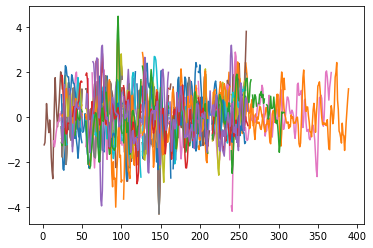

In [234]:
for z in z_scores_fixed:
    plt.plot(z)

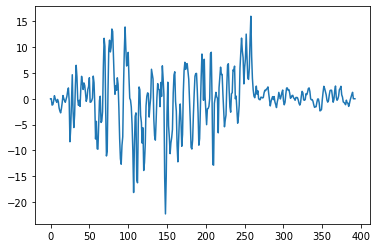

In [239]:
plt.plot(np.nansum(z_scores_fixed, axis=0))

In [46]:
from Bio.PDB import PDBParser

struct = PDBParser().get_structure(id='x', file="data/1r3u.pdb")

/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3408.
  PDBConstructionWarning,
/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3409.
  PDBConstructionWarning,
/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3414.
  PDBConstructionWarning,
/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3472.
  PDBConstructionWarning,


#### Scraps

In [10]:



    
# extract seq for all chains
# extract atom seq for all chains
# group by similarity
# for each group make multiple sequence alignment
# assign positions

# when reading the pdb file coordinates, assign each amino acid to the correct position

chain A
MASMTGGQQMGRGSSTSLYKKAGLMPSPMEDIEEILITEEQLKAKVKELGEMITRDYEGKDLVLIGVLKGAIMFMSGLSRAIDLPLSIDFLAVSSYGSSTKSSGIVKIIKDHDIDIEGKDVLIVEDIIDSGLTLAYLRETLLGRKPRSLKICTILDKPERREADVKVDYCGFKIPDKFVVGYGLDYAEKYRNLPFIGVLKPELYK
chain B
MASMTGGQQMGRGSSTSLYKKAGLMPSPMEDIEEILITEEQLKAKVKELGEMITRDYEGKDLVLIGVLKGAIMFMSGLSRAIDLPLSIDFLAVSSYGSSTKSSGIVKIIKDHDIDIEGKDVLIVEDIIDSGLTLAYLRETLLGRKPRSLKICTILDKPERREADVKVDYCGFKIPDKFVVGYGLDYAEKYRNLPFIGVLKPELYK


### What does the model look at to determine temperature?